# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?

Our business objective is to provide clients with the best understanding of property values for houses available in the market by using a model that incorporates several features in real estate. We want Zillow to be the market leader when it comes to home buying decisions, and in order to accomplish this we need to have the most accurate forecast for property investments. If we showed property values that were incorrect it could lead to customers using our service and being angry when the mortgage or bank does not appraise the property at the price we listed. If the banks do not value the property near our list price it would be a tremendous waste of time for our clients, cause mistrust in our data, and open the door for potential competitors.    


**1.2:**  How will your solution be used?

The model will solve clients needs for accurate listings of property values so they can make investment decisions according to their financial or personal objectives. We are going to use several real estate features in our model to predict property values that will be able to generalize larger samples so that this is scalable and profitable for the company. It will be most evident in Zillow's user interface where homes will appear with the best predicted price so clients can shop within their budget or according to their customizable selection of the perfect home.    


**1.3:**  How should success (or failure) be measured?

Our success will be measured from both a usage metric as this model should lead to more client hits on our app, and from a property perspective where we can find the difference between what a house sold for versus what we quantified it at. Negative feedback regarding our home value prediction would be a failure or an inability to model accurately depending on the location. This model should also help faciliate those looking to sell their homes, as well so we could expect a decrease in real estate invetory as turnover becomes quicker from more sales. 

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [3]:
df_zillow = pd.read_csv(filename)

In [4]:
df_zillow.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [5]:
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [6]:
df_zillow.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,assessmentyear,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
count,7.761300e+04,25007.000000,207.000000,50.000000,77579.000000,77579.000000,15.000000,49809.000000,76963.000000,614.0,...,223.000000,50703.000000,2393.000000,70.000000,77309.000000,17599.000000,77579.0,2900.000000,7.733200e+04,7.757800e+04
mean,1.300781e+07,1.812013,7.386473,679.720000,2.298496,3.053223,3.933333,6.533779,2.316392,66.0,...,6.040359,1.110309,305.460928,216.385714,1968.611507,1.434286,2016.0,14.088276,6.049667e+13,4.901506e+05
std,3.518717e+06,2.965768,2.728030,689.703546,0.996732,1.140480,0.258199,1.722062,0.979689,0.0,...,0.556035,1.169967,238.735241,190.177514,23.793171,0.544515,0.0,2.181281,1.533339e+12,6.537979e+05
min,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,...,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,2016.0,3.000000,6.037101e+13,1.000000e+03
25%,1.153821e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,...,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,2016.0,14.000000,6.037311e+13,2.068985e+05
50%,1.253004e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,...,6.000000,1.000000,250.000000,164.500000,1970.000000,1.000000,2016.0,15.000000,6.037603e+13,3.588785e+05
75%,1.421101e+07,1.000000,7.000000,796.500000,3.000000,4.000000,4.000000,8.000000,3.000000,66.0,...,6.000000,1.000000,364.000000,310.500000,1987.000000,2.000000,2016.0,15.000000,6.059042e+13,5.690000e+05
max,1.676893e+08,13.000000,21.000000,3560.000000,18.000000,16.000000,4.000000,12.000000,18.000000,66.0,...,13.000000,237.000000,3191.000000,868.000000,2016.000000,6.000000,2016.0,99.000000,4.830301e+14,4.906124e+07


In [7]:
#Total Missing
missing = df_zillow.isna().sum()

#Missing as %
missing_pct = 100 * missing / len(df_zillow)

#Convert to df
missing_df = (
    pd.DataFrame({
        'missing': missing,
        'missing_pct': missing_pct
    })
    .sort_values('missing_pct', ascending=False))

print(missing_df)


                              missing  missing_pct
buildingclasstypeid             77598    99.980673
finishedsquarefeet13            77571    99.945885
basementsqft                    77563    99.935578
storytypeid                     77563    99.935578
yardbuildingsqft26              77543    99.909809
fireplaceflag                   77441    99.778388
architecturalstyletypeid        77406    99.733292
typeconstructiontypeid          77390    99.712677
finishedsquarefeet6             77227    99.502661
pooltypeid10                    77148    99.400874
decktypeid                      76999    99.208895
poolsizesum                     76744    98.880342
pooltypeid2                     76539    98.616211
hashottuborspa                  76074    98.017085
yardbuildingsqft17              75220    96.916754
taxdelinquencyyear              74713    96.263513
taxdelinquencyflag              74713    96.263513
finishedsquarefeet15            74586    96.099880
finishedsquarefeet50           

In [8]:
df_zillow.nunique()

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

In [9]:
#Unique Counts in Order
unique_counts = df_zillow.nunique().sort_values(ascending=True)

print(unique_counts)


decktypeid                          1
pooltypeid7                         1
pooltypeid2                         1
pooltypeid10                        1
poolcnt                             1
hashottuborspa                      1
taxdelinquencyflag                  1
storytypeid                         1
fireplaceflag                       1
assessmentyear                      1
buildingclasstypeid                 2
regionidcounty                      3
fips                                3
typeconstructiontypeid              4
numberofstories                     4
threequarterbathnbr                 4
architecturalstyletypeid            5
fireplacecnt                        5
airconditioningtypeid               5
unitcnt                             8
heatingorsystemtypeid              10
buildingqualitytypeid              12
propertylandusetypeid              13
taxdelinquencyyear                 13
fullbathcnt                        13
finishedsquarefeet13               13
garagecarcnt

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

We can determine what features are categorical by the distinct number of values associated within the column along with their descriptions. For example a column like "airconditioningtypeid" has only five unique values out of roughly 78,000 entries and the description labels it as "typeid". In this context, it would be safe to assume that columns with the description of "typeid" and a low number of unique values should be classified as categorical in nature. 

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

Yes, the columns "rawcensustractandblock", "censustractandblock", and "taxdeliquency year" could be considered useless at first glance because they don't help predict total property value. The tax deliquency year column tells us when the owner failed to pay their property taxes which is more descriptive of the occupant, not the property. The other two columns concern census data regarding blocks and tracts that would not fall into scope for predicting property value because they are used more for demographic statistics.       

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

Yes, the values in column "buildingclasstypeid", "finishedsquarefeet13", "basementsqft", "storytypeid", and "yardbuildingsqft26" are missing from roughly 99.9% of all entries. While we want to mindful and plug-in missing values wherever possible either through averages or grouping, we need to understand columns with this many missing values are pointless to our research.

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Yes, the "parcelid" has a 77,414 unique values out of 77,613 entries meaning almost every single "parcelid" is different. While unique values can help us train our model for predictions, we need to be mindful of instances where each row is different and as such has little to offer in terms of predictive potential. 

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

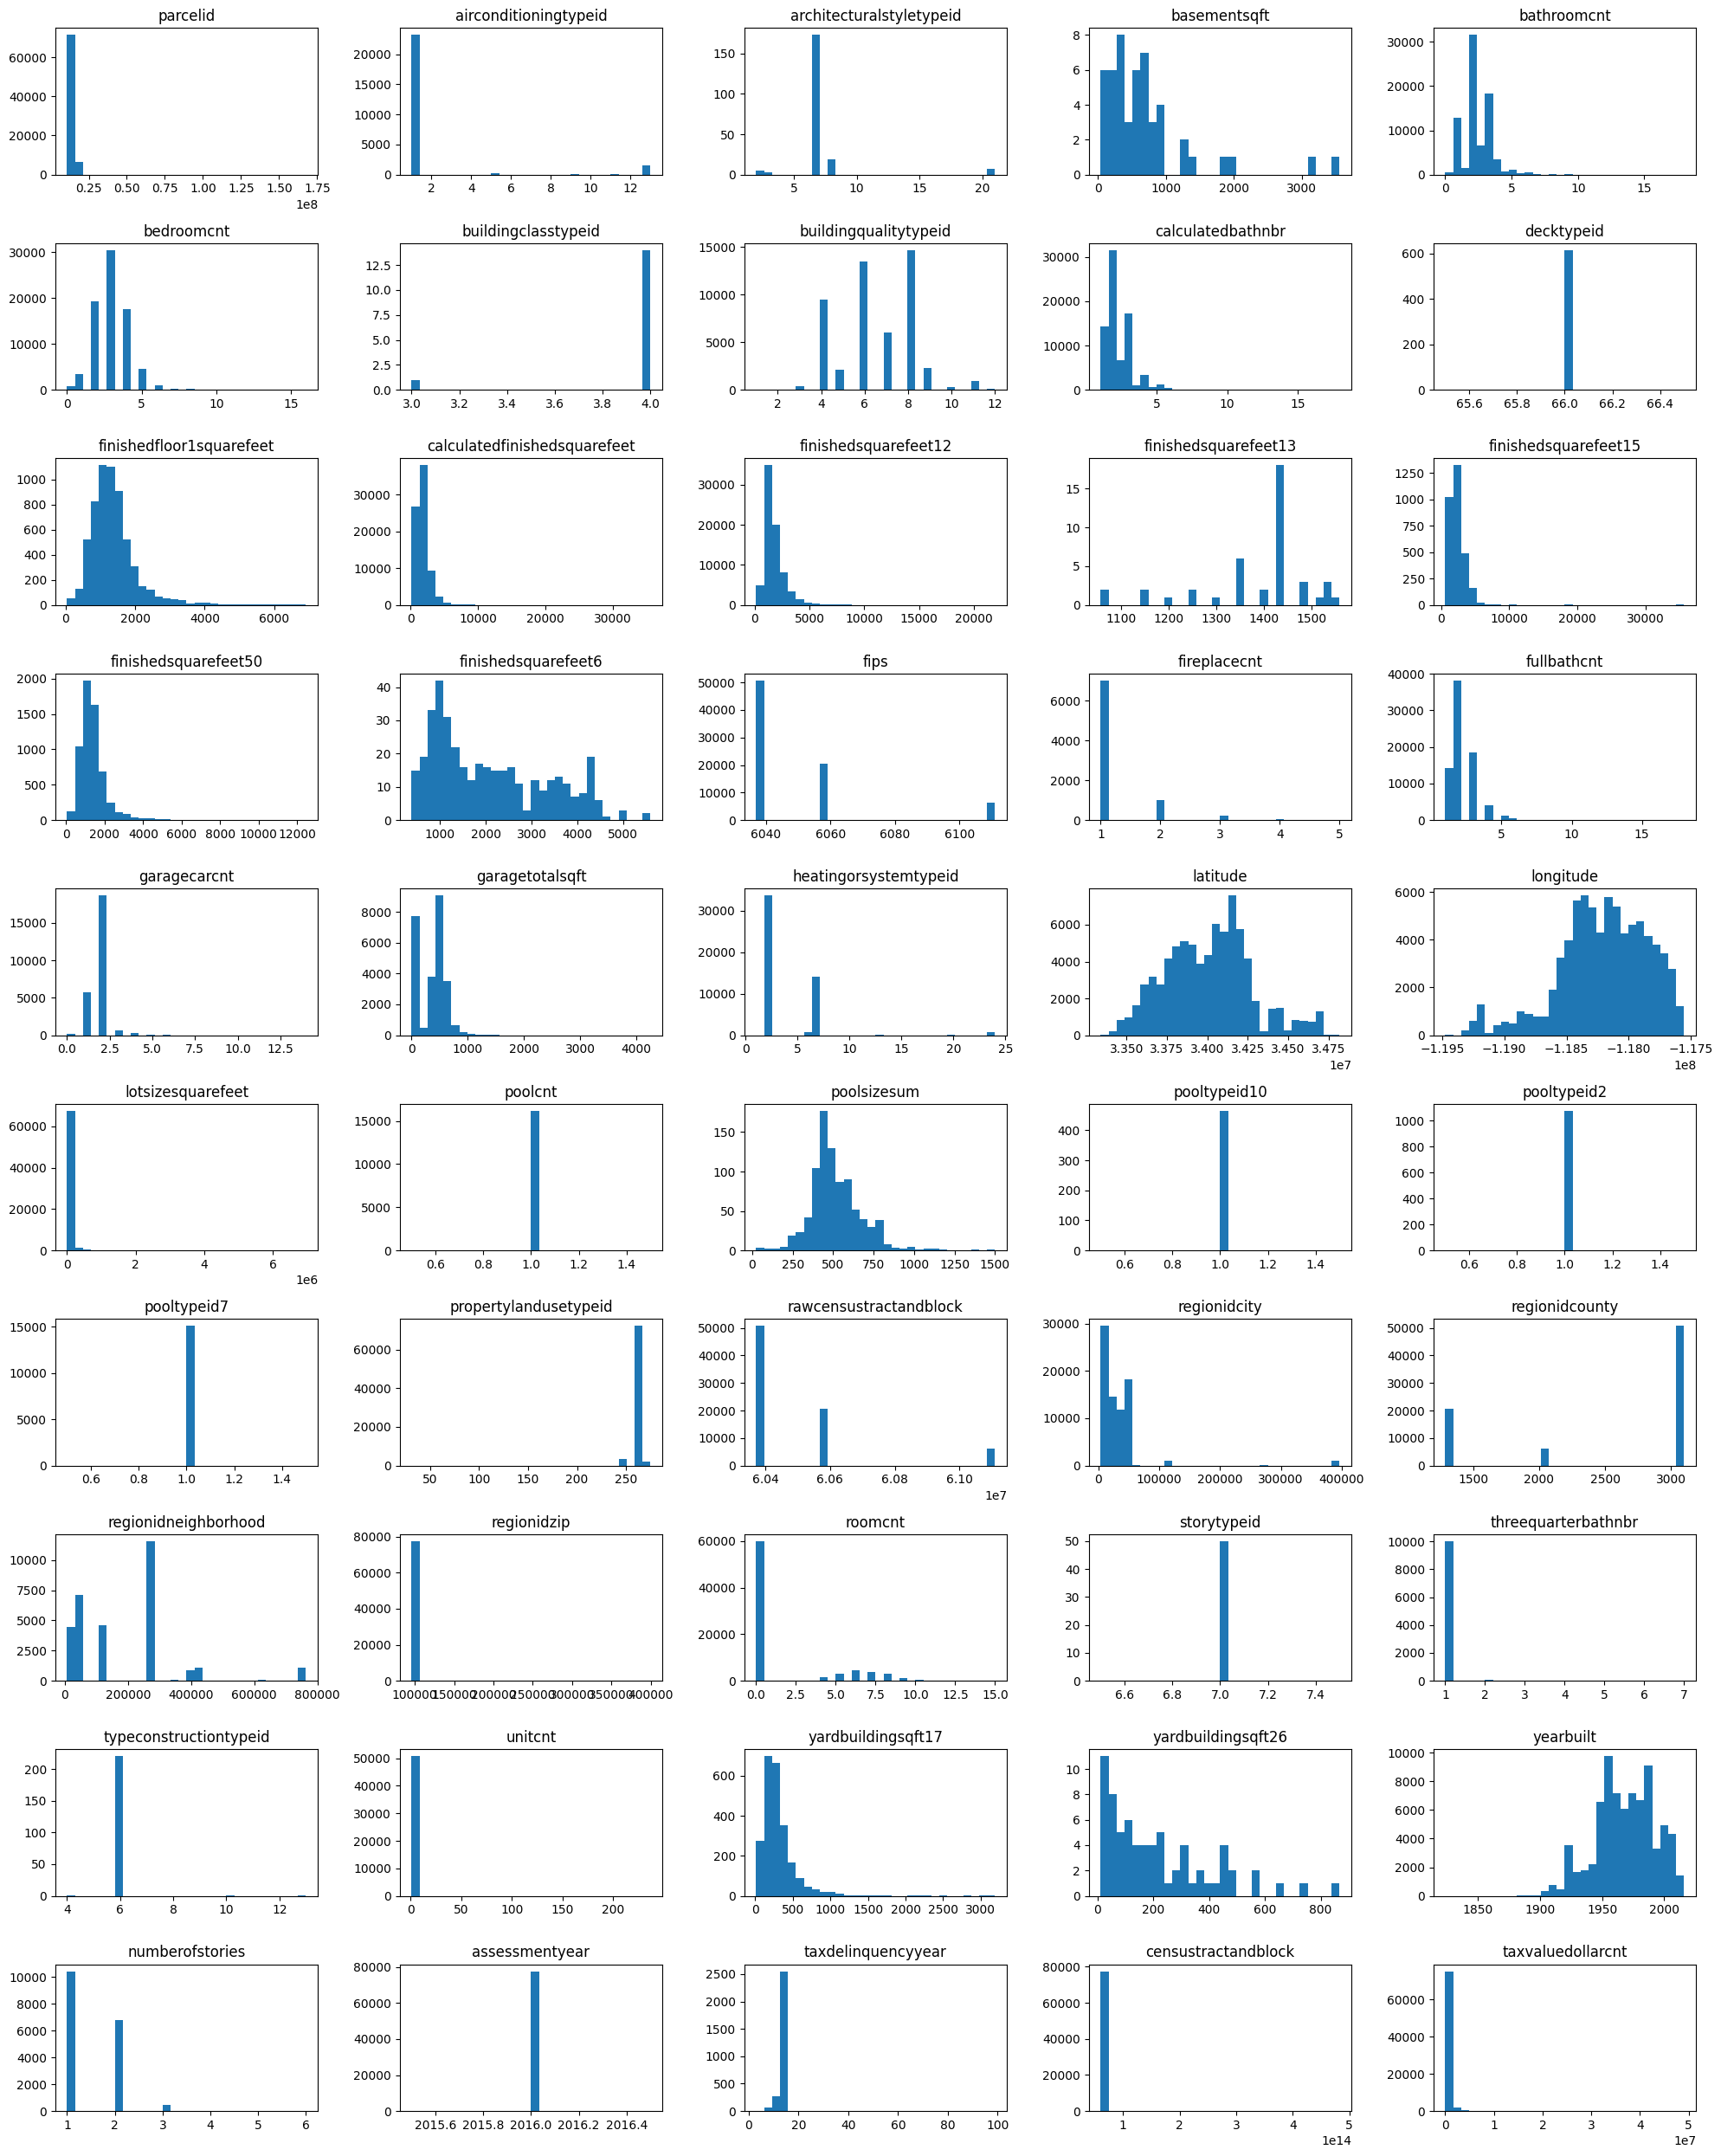

In [10]:
# Feature Histograms
df_zillow.hist(
    figsize=(20, 25),    
    layout=(-1, 5),      
    bins=30,             
    grid=False           
)

plt.tight_layout()      
plt.show()


In [11]:
# Feature Exploratoin
num = df_zillow.select_dtypes(include=["float64","int64"])

# Full correlation matrix
corr_matrix = num.corr()

# Display
top_feats = corr_matrix["taxvaluedollarcnt"]\
             .abs()\
             .sort_values(ascending=False)

print(top_feats.head(15))


taxvaluedollarcnt               1.000000
finishedsquarefeet12            0.606334
calculatedfinishedsquarefeet    0.583155
finishedfloor1squarefeet        0.565043
finishedsquarefeet50            0.559625
basementsqft                    0.493777
calculatedbathnbr               0.484819
fullbathcnt                     0.472832
bathroomcnt                     0.461013
fireplacecnt                    0.435830
yardbuildingsqft17              0.401433
garagetotalsqft                 0.345202
garagecarcnt                    0.328466
buildingqualitytypeid           0.327590
finishedsquarefeet15            0.309188
Name: taxvaluedollarcnt, dtype: float64


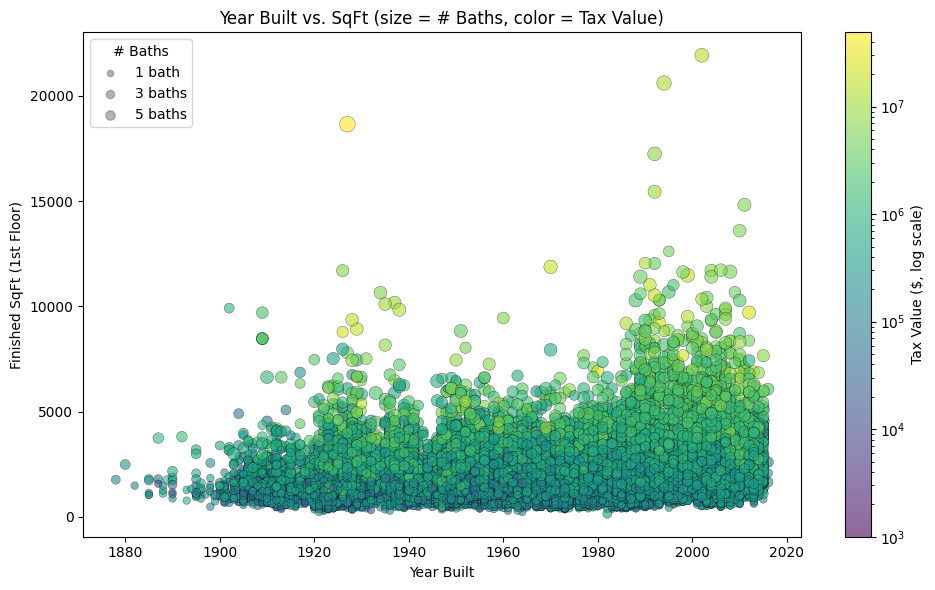

In [35]:
from matplotlib.colors import LogNorm

# Year with Squarefeet, full baths, to value
cols    = ["yearbuilt", "finishedsquarefeet12", "fullbathcnt", "taxvaluedollarcnt"]
df_plot = df_zillow[cols].dropna()

# Bathroom Scaler
sizes = np.sqrt(df_plot["fullbathcnt"]) * 30

# Scatter
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df_plot["yearbuilt"],
    df_plot["finishedsquarefeet12"],
    c=df_plot["taxvaluedollarcnt"],
    cmap="viridis",
    norm=LogNorm(),       
    s=sizes,              
    alpha=0.6, #adjust here for transparency if needed
    edgecolor="k",        
    linewidth=0.3
)

# Label
plt.xlabel("Year Built")
plt.ylabel("Finished SqFt (1st Floor)")
plt.title("Year Built vs. SqFt (size = # Baths, color = Tax Value)")
cbar = plt.colorbar(sc, label="Tax Value ($, log scale)")

# Legend
for bath_count in [1, 3, 5]:
    plt.scatter([], [], s=np.sqrt(bath_count)*20,
                c="gray", alpha=0.6,
                label=f"{bath_count} bath{'s' if bath_count>1 else ''}")
plt.legend(scatterpoints=1, frameon=True, title="# Baths", loc="upper left")

plt.tight_layout()
plt.show()




<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

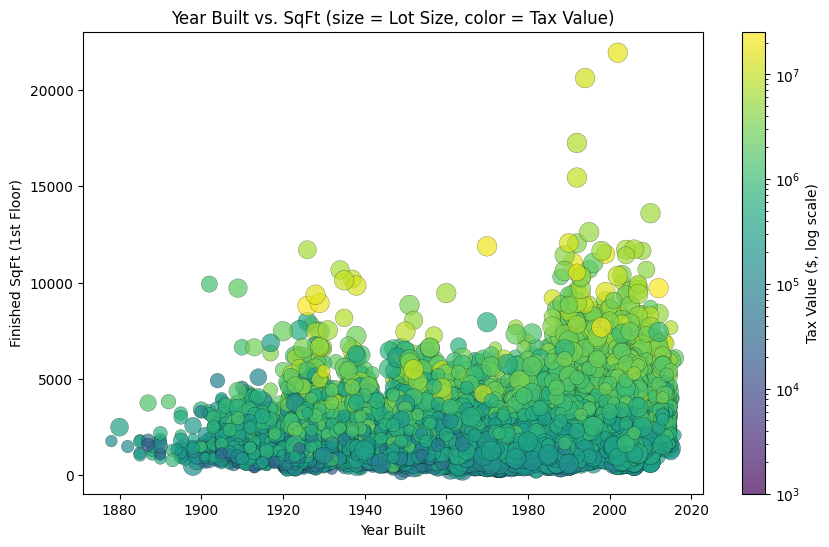

In [ ]:

# Pull & Clean
cols    = ["yearbuilt","finishedsquarefeet12","lotsizesquarefeet","taxvaluedollarcnt"]
df_plot = df_zillow[cols].dropna()

# Lot Size
sizes = np.sqrt(df_plot["lotsizesquarefeet"])
sizes = np.clip(sizes, a_min=10, a_max=200)   

# Scatter
plt.figure(figsize=(10,6))
sc = plt.scatter(
    df_plot["yearbuilt"],             
    df_plot["finishedsquarefeet12"],  
    c=df_plot["taxvaluedollarcnt"],   
    cmap="viridis",
    norm=LogNorm(),                   
    s=sizes,                          
    alpha=0.7,
    edgecolor="k", linewidth=0.2
)

# Plot
plt.xlabel("Year Built")
plt.ylabel("Finished SqFt (1st Floor)")
plt.title("Year Built vs. SqFt (size = Lot Size, color = Tax Value)")
cbar = plt.colorbar(sc, label="Tax Value ($, log scale)")

# Legend
for lot in [400, 1000, 5000]:  
    plt.scatter([], [], s=np.clip(np.sqrt(lot),10,200),
                c="gray", alpha=0.7, edgecolor="k",
                label=f"{lot:,} sqft")
plt.legend


/tmp/ipykernel_2498/2886519416.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


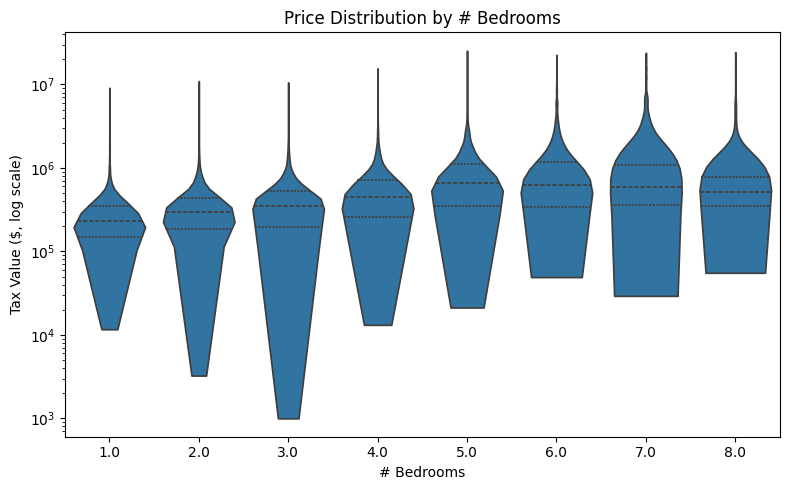

In [46]:
# Violin Plot 
plt.figure(figsize=(8,5))
sns.violinplot(
    x="bedroomcnt",
    y="taxvaluedollarcnt",
    data=df_zillow.query("1 <= bedroomcnt <= 8"),  
    inner="quartile",      
    scale="width",         
    cut=0    
)
plt.yscale("log")
plt.xlabel("# Bedrooms")
plt.ylabel("Tax Value ($, log scale)")
plt.title("Price Distribution by # Bedrooms")
plt.tight_layout()
plt.show()



#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?  
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?
From the scatterplot it is clear that houses that were built in more recent years tend to have higher property values especially when factoring in square feet and lot size. I would classify this is a positively skewed distribution because of the increase over the features with the light yellow mostly in the top right with the darker less expensive in the bottom left. I selected these features because of the .corr() output that showed "finishedsquarefeet12" as one of the highest features correlated with overall property value. When looking at the price distribution by bedroom count I noticed that all of the violins have a very long upward tail which means there could be some extreme outliers for prices. I also noticed that there is a very low dip in the violins with 2-3 bedrooms which could be a sign of missing or incorrect property values; we might want to filter out some of these from our overall model to ensure accuracy with our predictions.  

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

